# Testing out different methods of normalizing the cholera cases
Using the WorldPop data from HDX: https://data.humdata.org/dataset/worldpop-population-counts-2015-2030-moz



In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [ ]:
# Data and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from pathlib import Path
from matplotlib.patches import Rectangle
import calendar

import os
import re
import rasterio
import geopandas as gpd
import rasterstats as rs
from fuzzywuzzy import process
from unidecode import unidecode
from src.constants import *
from src.utils import *

# Display settings
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.1f}".format
sns.set(style="whitegrid")

In [3]:
# load admin boundaries
adm2_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm2_ine_20190607.shp"
)
gdf_adm2 = gpd.read_file(adm2_path)

In [20]:
district_df = pd.read_csv(
    Path(os.getenv("AA_DATA_DIR"))
    / "private"
    / "processed"
    / "moz"
    / "cholera"
    / "cholera_data_cleaned.csv"
)
# only keep those with week values
district_df = district_df[district_df["week"].notna()]

In [21]:
# using the 2025 file
# worldpop_data_url = "https://data.worldpop.org/GIS/Population/Global_2015_2030/R2024B/2025/MOZ/v1/100m/constrained/moz_pop_2025_CN_100m_R2024B_v1.tif"
gdf_adm2_pop = pd.read_csv(
    Path(AA_DATA_DIR)
    / "public"
    / "processed"
    / "moz"
    / "worldpop"
    / "adm2_population_totals.csv"
)
gdf_adm2 = gdf_adm2.merge(
    gdf_adm2_pop,
    how="left",
    on="ADM2_PCODE",
    suffixes=("", "_pop"),
)

In [22]:
# it seems the admin bounds districts are not matching the cholera data ones
# trying some fuzzy matching to see if we can get a match


# add the population data to the gdf
pop_df = gdf_adm2[["ADM2_PT", "ADM1_PT", "sum_population"]].copy()
district_df.loc[:, "district_norm"] = district_df["district"].apply(normalize)
pop_df["ADM2_PT_norm"] = pop_df["ADM2_PT"].apply(normalize)
mapping = {}
for name in district_df["district_norm"]:
    result = process.extractOne(name, pop_df["ADM2_PT_norm"])
    if result:
        match, score = result[0], result[1]
    if score >= 80:  # threshold for matching
        match_row = pop_df[pop_df["ADM2_PT_norm"] == match].iloc[0]
        mapping[name] = match_row["ADM2_PT"]
district_df["matched_name"] = district_df["district_norm"].map(mapping)
district_df["date"] = pd.to_datetime(
    district_df["year"].astype(str)
    + district_df["week"].astype(int).astype(str).str.zfill(2)
    + "1",
    format="%G%V%u",
)
# Normalise the cholera data by population
district_pop_df = district_df.merge(
    pop_df, left_on="matched_name", right_on="ADM2_PT", how="left"
)

In [42]:
# check if merging is done well
# it should be empty if all the names are matched
district_pop_df[district_pop_df["ADM2_PT"].isna()][
    [
        "province",
        "district",
        "matched_name",
    ]
].drop_duplicates()

,province,district,matched_name


In [43]:
# now, normalise the cholera data by population
district_pop_df["cases_per_100k"] = (
    district_pop_df["cases"] / district_pop_df["sum_population"]
) * 100000
district_pop_df["cases_per_100k"].describe()

count   13,488.0
mean        23.4
std         26.8
min          0.0
25%          5.4
50%         14.3
75%         32.2
max        774.4
Name: cases_per_100k, dtype: float64

In [44]:
# check the distribution of the cases per 100k
# look at 99th percentile to set a trigger for each province OR 4x weekly increase in cases
# Calculate percentiles per province
percentiles = (
    district_pop_df[district_pop_df["cases_per_100k"] > 0]
    .groupby("province")["cases_per_100k"]
    .quantile([0.99])
    .unstack()
)

# Merge percentiles back into the main df
district_df_with_percentiles = district_pop_df.merge(
    percentiles.rename(columns={0.99: "p99"}),
    left_on="province",
    right_index=True,
    how="left",
)
district_df_with_percentiles["weekly_pct_increase"] = (
    district_df_with_percentiles
    # group by district and calculate percentage change
    .groupby("district")["cases_per_100k"].pct_change(fill_method=None)
    * 100
)

In [45]:
# Check if cases cross the thresholds
district_df_with_percentiles["above_99th"] = (
    district_df_with_percentiles["cases_per_100k"]
    > district_df_with_percentiles["p99"]
)
district_df_with_percentiles["above_4x"] = (
    district_df_with_percentiles["weekly_pct_increase"] >= 400
)
district_df_with_percentiles["threshold_crossed"] = (
    district_df_with_percentiles["above_99th"]
    | district_df_with_percentiles["above_4x"]
)
district_df_with_percentiles = district_df_with_percentiles.sort_values(
    ["district", "year", "week"]
)
# Create the new column: True only if this week and the previous two weeks are above the 99th percentile
district_df_with_percentiles["three_consec_crossing"] = (
    district_df_with_percentiles["threshold_crossed"]
    & district_df_with_percentiles.groupby("district")[
        "threshold_crossed"
    ].shift(1)
    & district_df_with_percentiles.groupby("district")[
        "threshold_crossed"
    ].shift(2)
    & (
        (
            (district_df_with_percentiles["province"] == "Zambezia")
            & (district_df_with_percentiles["cases"] >= 100)
        )
        | (
            (district_df_with_percentiles["province"] == "Nampula")
            & (district_df_with_percentiles["cases"] >= 100)
        )
    )
)
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
][["province", "district"]].drop_duplicates()

,province,district
835,Nampula,Ilha de Moçambique
1305,Nampula,Lalaua
10756,Zambezia,Maganja
6349,Nampula,Nacala-Porto
13481,Zambezia,Nicoadal


In [46]:
# Compute total cases and total cases relative to population per district per year
grouped = (
    district_df_with_percentiles.groupby(["district", "year"])
    .agg(
        average_cases=("cases", "mean"),
        average_cases_per_100k=("cases_per_100k", "mean"),
    )
    .reset_index()
)

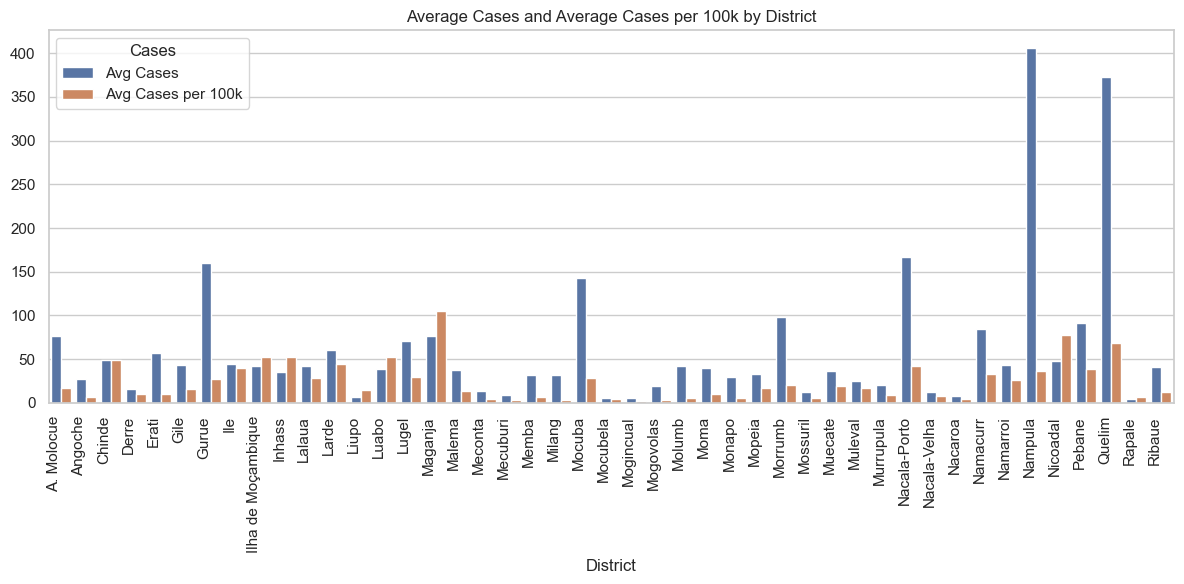

In [47]:
melted = grouped.melt(
    id_vars="district",
    value_vars=["average_cases", "average_cases_per_100k"],
    var_name="metric",
    value_name="value",
)

# Rename for cleaner labels
melted["cases"] = melted["metric"].replace(
    {
        "average_cases": "Avg Cases",
        "average_cases_per_100k": "Avg Cases per 100k",
    }
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=melted,
    x="district",
    y="value",
    hue="cases",
    dodge=True,
    errorbar=None,
)
plt.title("Average Cases and Average Cases per 100k by District")
plt.xlabel("District")
plt.xticks(rotation=90, ha="right")
plt.ylabel("")
plt.legend(title="Cases")
plt.tight_layout()
plt.show()

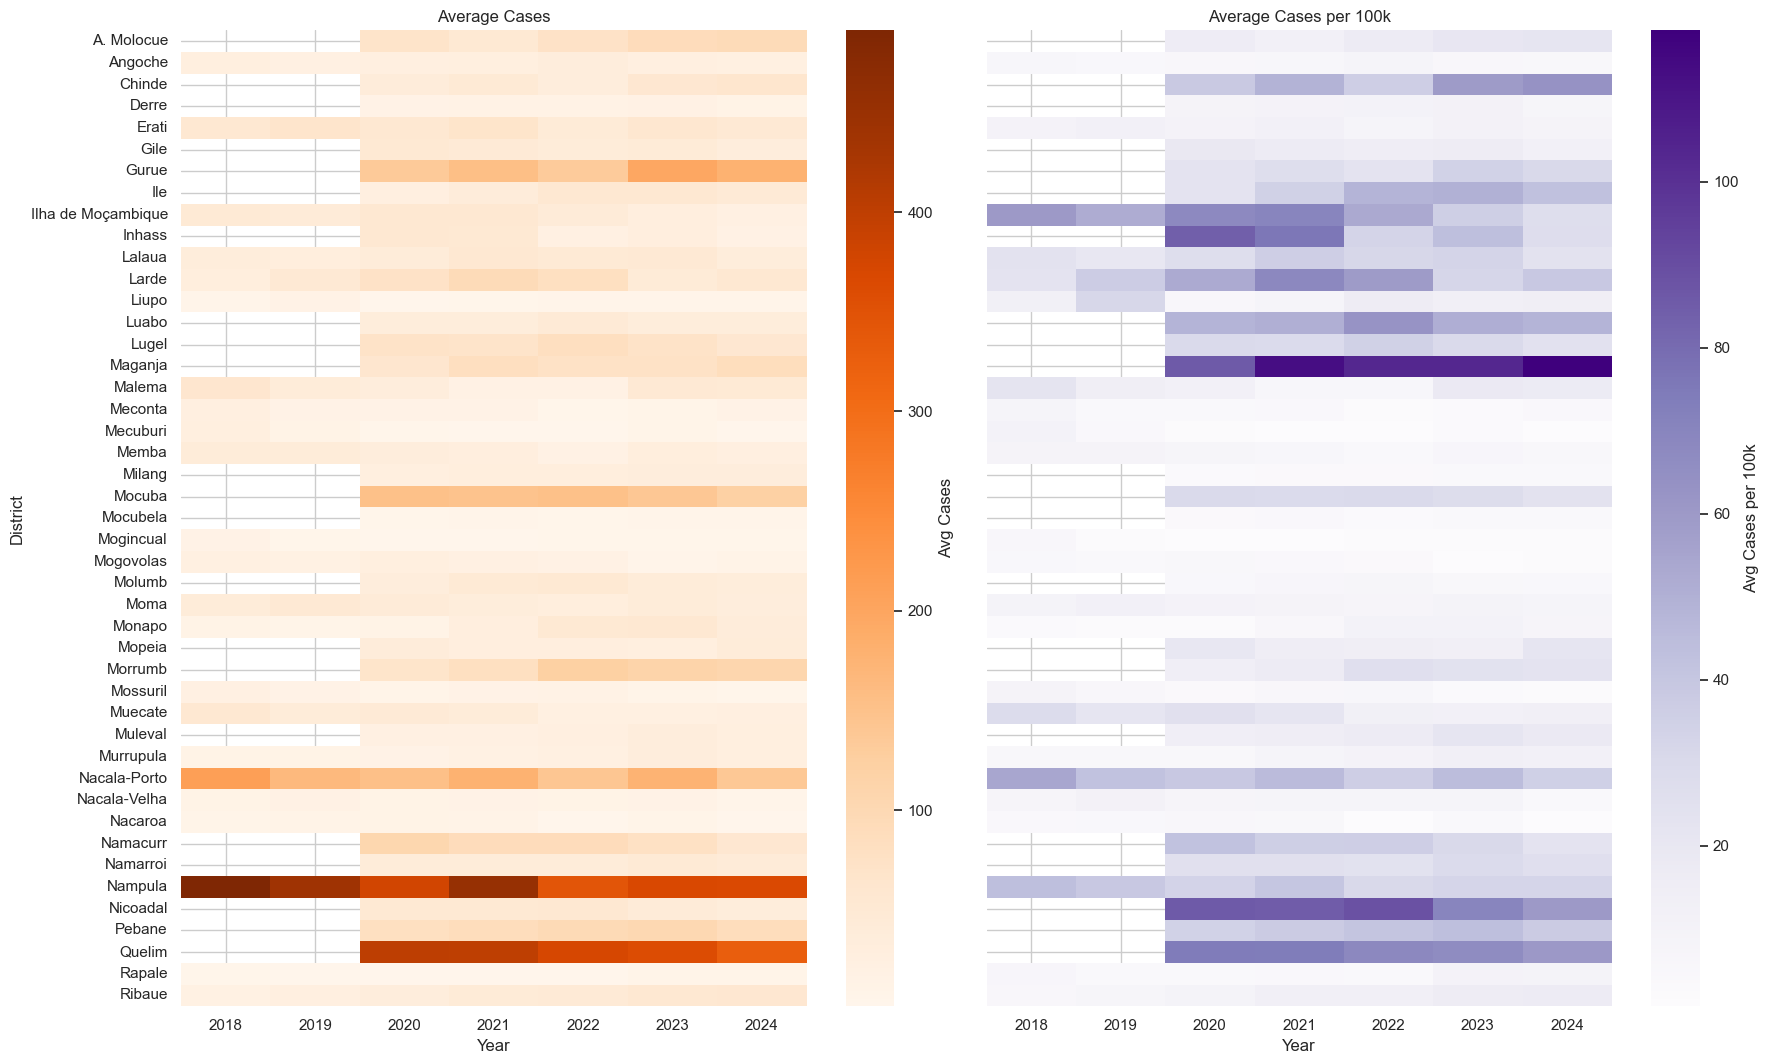

In [48]:
cases_pivot = grouped.pivot(
    index="district", columns="year", values="average_cases"
)
cases_per_100k_pivot = grouped.pivot(
    index="district", columns="year", values="average_cases_per_100k"
)

fig, axes = plt.subplots(1, 2, figsize=(18, 10.8), sharey=True)

sns.heatmap(
    cases_pivot,
    cmap="Oranges",
    annot=False,
    cbar_kws={"label": "Avg Cases"},
    ax=axes[0],
)
axes[0].set_title("Average Cases")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("District")

sns.heatmap(
    cases_per_100k_pivot,
    cmap="Purples",
    annot=False,
    cbar_kws={"label": "Avg Cases per 100k"},
    ax=axes[1],
)
axes[1].set_title("Average Cases per 100k")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [49]:
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
][["year", "week"]].drop_duplicates().sort_values(["year", "week"])
# the number of districts by year and by province when the threshold was crossed
all_years = district_df_with_percentiles["year"].unique()
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
].groupby(["province", "year"])["district"].nunique().unstack(
    fill_value=0
).reindex(
    columns=sorted(all_years), fill_value=0
)

year,2018,2019,2020,2021,2022,2023,2024
province,,,,,,,
Nampula,0,0,1,2,3,0,0
Zambezia,0,0,1,1,0,1,1


In [50]:
# Filter if you want only the crossings
crossed_99th = district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
]

district_trigger_99th = (
    crossed_99th.groupby(["province", "district", "year"])["week"]
    .count()
    .reset_index(name="week_count")
)
district_trigger_99th

,province,district,year,week_count
0,Nampula,Ilha de Moçambique,2020,3
1,Nampula,Ilha de Moçambique,2021,6
2,Nampula,Ilha de Moçambique,2022,4
3,Nampula,Lalaua,2022,2
4,Nampula,Nacala-Porto,2021,7
5,Nampula,Nacala-Porto,2022,1
6,Zambezia,Maganja,2020,1
7,Zambezia,Maganja,2021,3
8,Zambezia,Maganja,2024,7
9,Zambezia,Nicoadal,2023,1


In [52]:
highlight_cells = [
    (2020, "April"),
    (2024, "January"),
]

In [53]:
month_num = {
    month: idx for idx, month in enumerate(calendar.month_name) if month
}


def highlight_month_boxes(data, cerf_y_lim="cases_per_100k", **kwargs):
    ax = plt.gca()

    # Add vertical lines
    consec_dates = data.loc[
        data["three_consec_crossing"], "date"
    ].sort_values()

    if not consec_dates.empty:
        # Convert to periods (daily)
        diffs = consec_dates.diff().dt.days.fillna(1)
        group = (diffs != 7).cumsum()  # Use 7 for weekly data

        for _, g in consec_dates.groupby(group):
            start = g.min()
            end = g.max()
            y_min = data.loc[
                (data["date"] >= start) & (data["date"] <= end),
                "cases_per_100k",
            ].min()
            y_max = data.loc[
                (data["date"] >= start) & (data["date"] <= end),
                "cases_per_100k",
            ].max()
            ax.add_patch(
                Rectangle(
                    (start, 0),
                    end - start,
                    ax.get_ylim()[1],
                    facecolor="red",
                    alpha=0.5,
                    edgecolor="red",
                )
            )

    # Highlight selected months
    for year, month in highlight_cells:
        month_index = month_num.get(month)
        if not month_index:
            continue

        mask = (data["date"].dt.year == year) & (
            data["date"].dt.month == month_index
        )
        if not mask.any():
            continue

        month_data = data.loc[mask]
        x_min = month_data["date"].min()
        x_max = month_data["date"].max()
        y_min = max(0, month_data[cerf_y_lim].min() - 5)
        y_max = month_data[cerf_y_lim].max() + 5

        ax.add_patch(
            Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                facecolor="green",
                edgecolor="green",
                alpha=0.5,
                linewidth=1,
            )
        )

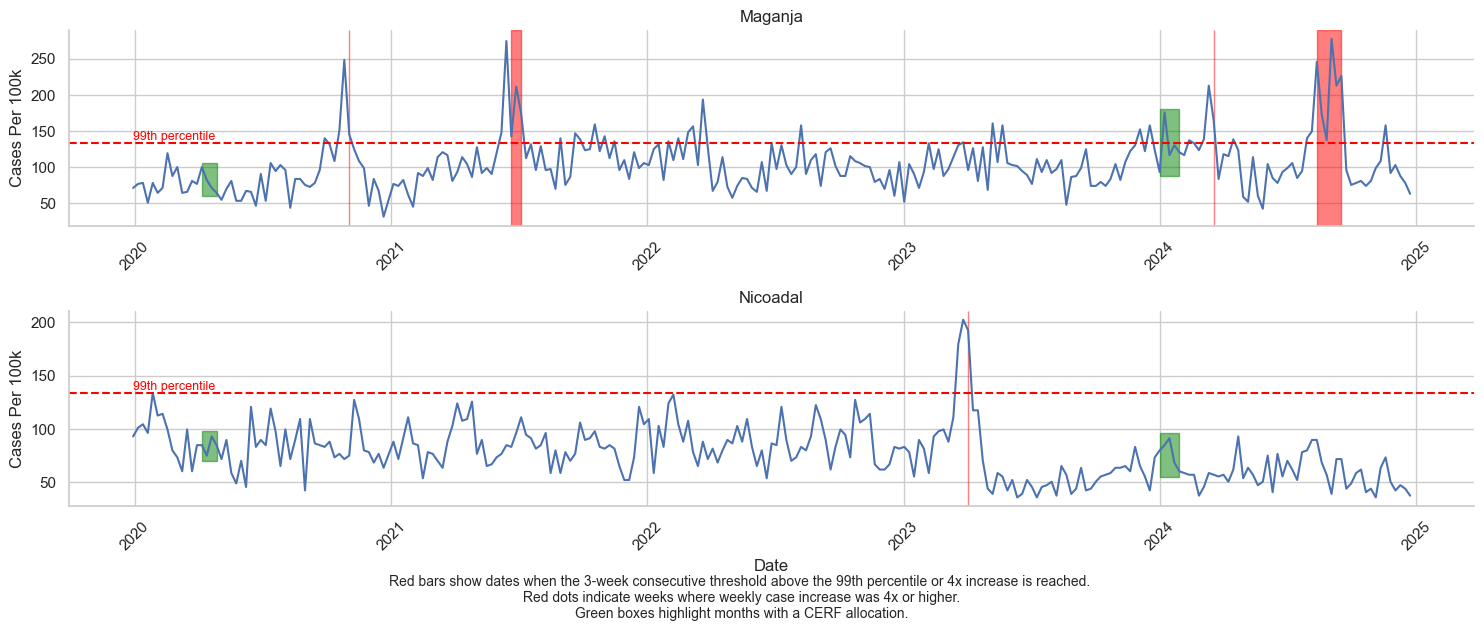

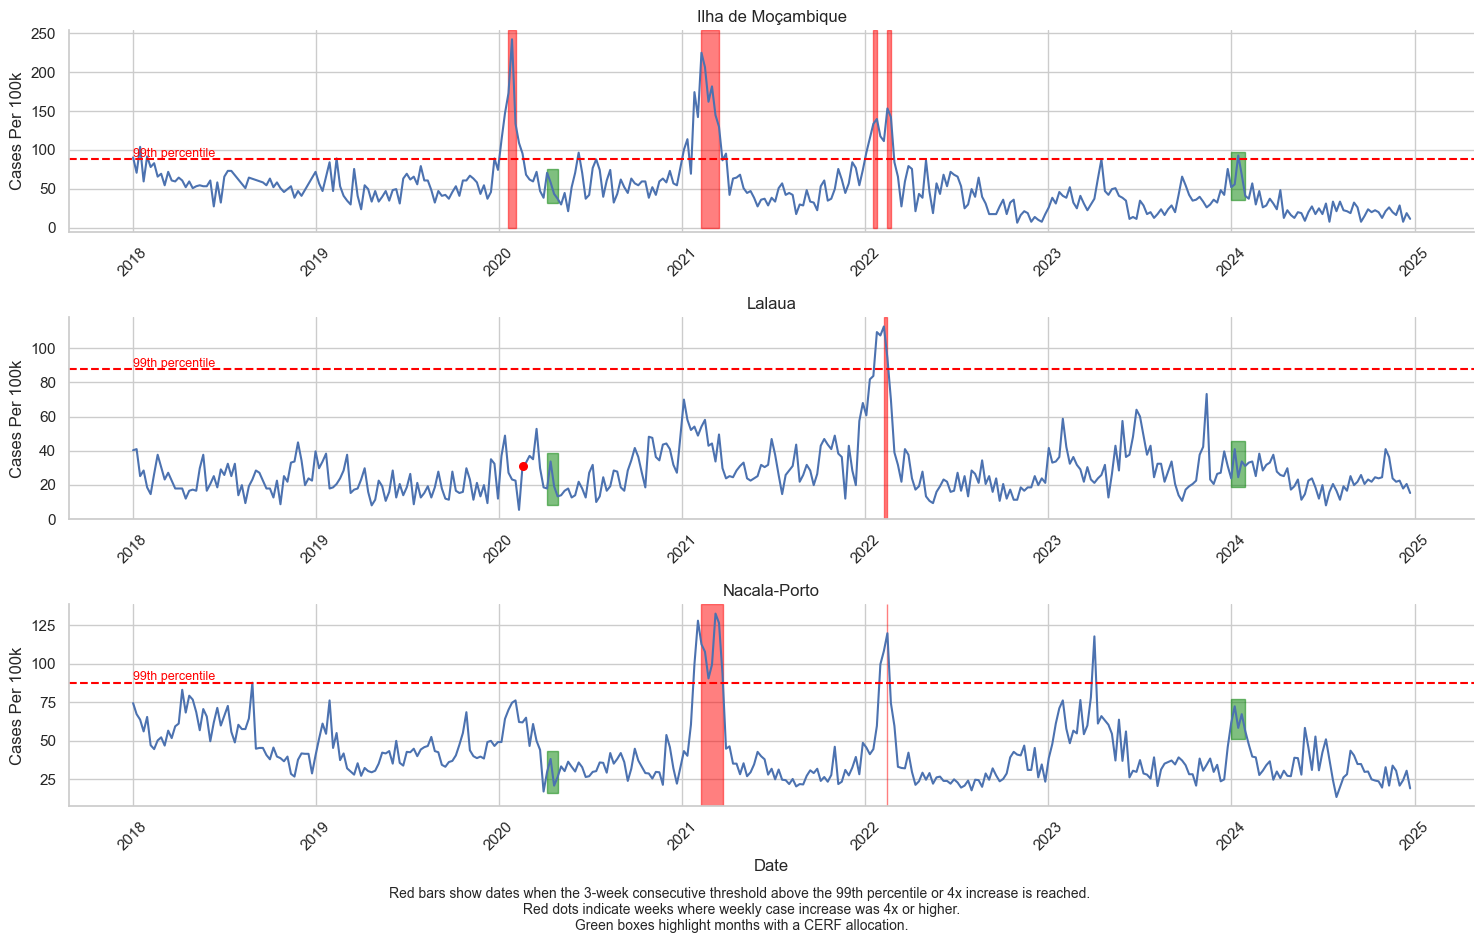

In [54]:
unique_provinces = district_df_with_percentiles["province"].unique()

for province in unique_provinces:
    subset = district_df_with_percentiles[
        (district_df_with_percentiles["province"] == province)
        & (
            district_df_with_percentiles["district"].isin(
                district_trigger_99th["district"].unique()
            )
        )
    ]

    if subset.empty:
        continue

    g = sns.FacetGrid(
        subset,
        col="district",
        col_wrap=1,
        sharex=False,
        sharey=False,
        height=3,
        aspect=5,
    )

    # Plot main line
    g.map_dataframe(sns.lineplot, x="date", y="cases_per_100k")
    # g.map_dataframe(
    #    sns.lineplot,
    #    x="date",
    #    y="cases",
    #    linestyle="--",
    #    color="orange",
    #    label="Actual Cases",
    # )

    # Add horizontal 99th percentile line
    g.map_dataframe(
        lambda data, color, **kws: (
            plt.axhline(y=data["p99"].iloc[0], color="red", linestyle="--"),
            plt.text(
                data["date"].min(),
                data["p99"].iloc[0],
                "99th percentile",
                color="red",
                fontsize=9,
                verticalalignment="bottom",
                horizontalalignment="left",
            ),
        ),
    )
    g.map_dataframe(
        lambda data, **kws: plt.scatter(
            data.loc[data["weekly_pct_increase"] >= 400, "date"],
            data.loc[data["weekly_pct_increase"] >= 400, "cases_per_100k"],
            color="red",
            s=30,
            zorder=5,
        )
    )

    # Add vertical red lines where condition is true
    def add_vertical_lines(data, **kwargs):
        for date in data.loc[data["three_consec_crossing"], "date"]:
            plt.axvline(x=date, color="red", linestyle="-", linewidth=1)

    # g.map_dataframe(add_vertical_lines)
    g.map_dataframe(highlight_month_boxes)
    g.set_titles(f"{{col_name}}")
    g.set_axis_labels("Date", "Cases Per 100k")

    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)

    plt.tight_layout()
    plt.figtext(
        0.5,
        -0.04,
        "Red bars show dates when the 3-week consecutive threshold above the 99th percentile or 4x increase is reached. \n "
        "Red dots indicate weeks where weekly case increase was 4x or higher. \n"
        "Green boxes highlight months with a CERF allocation.",
        wrap=True,
        horizontalalignment="center",
        fontsize=10,
    )
    plt.show()

In [56]:
# showing summary by province
trigger_df = district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"] == True
].copy()

# Extract month and year
trigger_df["month"] = pd.to_datetime(trigger_df["date"]).dt.month_name()
trigger_df["year"] = pd.to_datetime(trigger_df["date"]).dt.year

# Group by province, year, month
summary = (
    trigger_df.groupby(["ADM1_PT", "year", "month"])
    .agg(
        num_trigger_weeks=("week", "nunique"),
        cases_per_100k=("cases_per_100k", "first"),
        districts=("district", lambda x: ", ".join(sorted(set(x)))),
    )
    .reset_index()
    .rename(columns={"ADM1_PT": "province"})
    .sort_values(["province", "year", "month"])
)

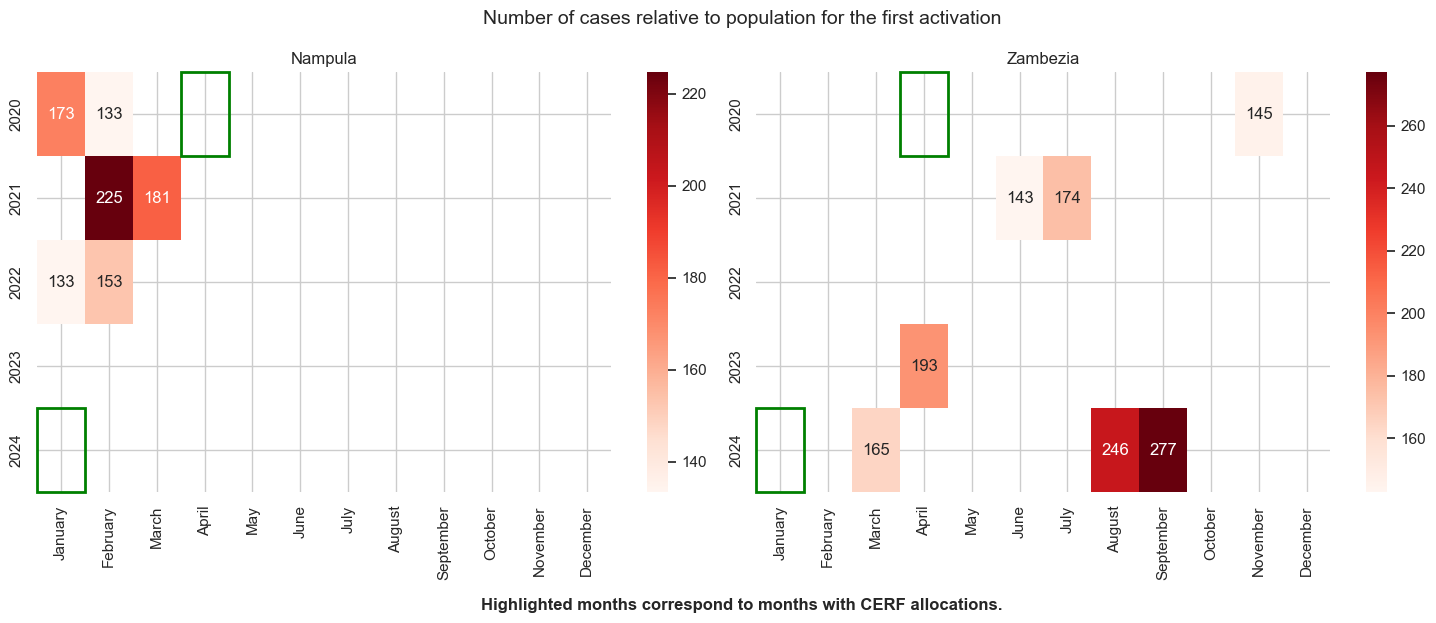

In [64]:
# Ensure months are ordered
month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
summary["month"] = pd.Categorical(
    summary["month"], categories=month_order, ordered=True
)

# Pivot the data
pivot = summary.pivot_table(
    values="cases_per_100k",
    index="year",
    columns="month",
    aggfunc="first",
    observed=False,
).sort_index()

all_years = list(range(summary["year"].min(), summary["year"].max() + 1))

# Faceted heatmap
g = sns.FacetGrid(
    summary,
    col="province",
    col_wrap=2,
    height=6,
    aspect=1.25,
    sharex=False,
    sharey=False,
)


def heatmap_with_all_years(data, **kwargs):
    table = data.pivot_table(
        index="year",
        columns="month",
        values="cases_per_100k",
        aggfunc="first",
        observed=False,
    ).reindex(index=all_years, columns=month_order)

    sns.heatmap(
        table,
        cmap="Reds",
        cbar=True,
        annot=True,
        fmt=".0f",
        linewidths=0,
        linecolor=None,
    )
    ax = plt.gca()

    # Outline targets
    highlight_cells = [
        (2020, "April"),
        (2024, "January"),
    ]

    # Loop and draw rectangles
    for year, month in highlight_cells:
        try:
            row_idx = table.index.get_loc(year)
            col_idx = table.columns.get_loc(month)
            ax.add_patch(
                plt.Rectangle(
                    (col_idx, row_idx),
                    1,
                    1,
                    fill=False,
                    edgecolor="green",
                    linewidth=2,
                    clip_on=False,
                )
            )
        except KeyError:
            continue


g.map_dataframe(heatmap_with_all_years)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "")
g.fig.suptitle(
    "Number of cases relative to population for the first activation",
    fontsize=14,
)
plt.figtext(
    0.5,
    -0.02,
    "Highlighted months correspond to months with CERF allocations.",
    ha="center",
    fontsize=12,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

In [ ]:
summary["district_count"] = (
    summary["districts"]
    .str.split(",")
    .apply(lambda x: len([d.strip() for d in x if d.strip()]))
)

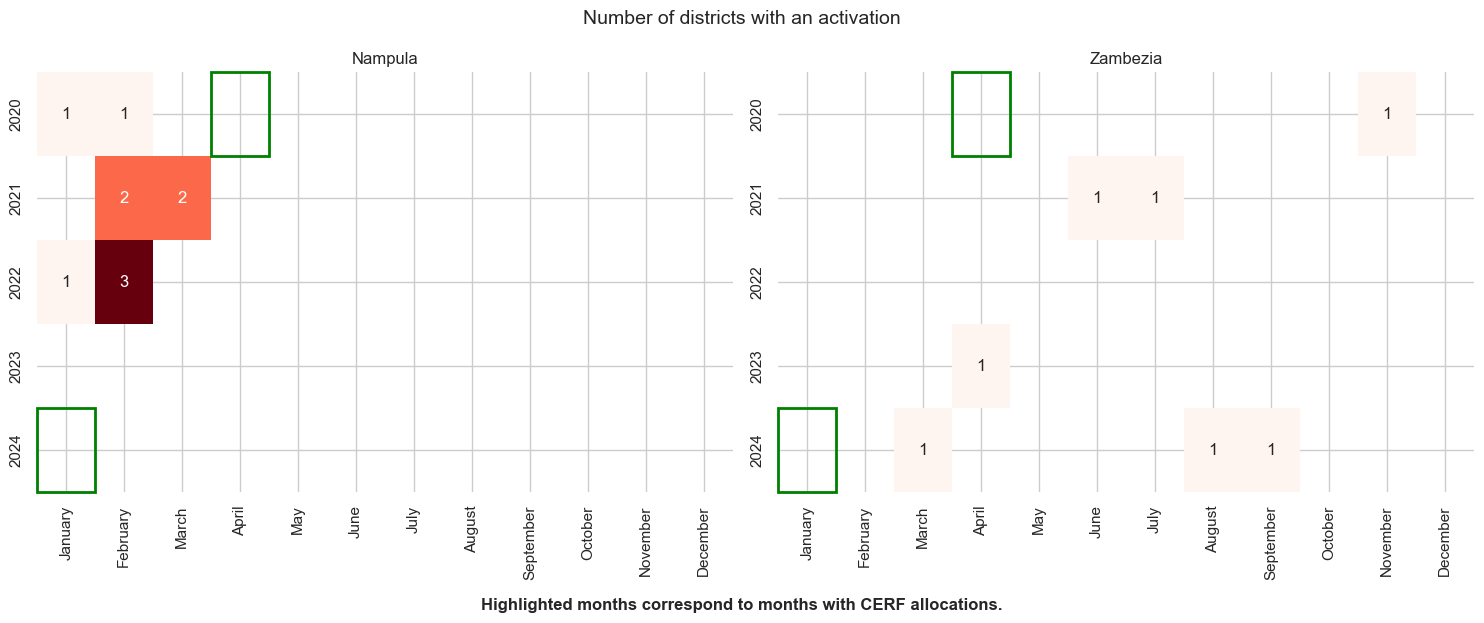

In [ ]:
# Pivot the data
pivot_dist = summary.pivot_table(
    values="district_count",
    index="year",
    columns="month",
    aggfunc="mean",
    observed=False,
).sort_index()

all_years = list(range(summary["year"].min(), summary["year"].max() + 1))

# Faceted heatmap
g = sns.FacetGrid(
    summary,
    col="province",
    col_wrap=2,
    height=6,
    aspect=1.25,
    sharex=False,
    sharey=False,
)


def heatmap_with_all_years(data, **kwargs):
    table = data.pivot_table(
        index="year",
        columns="month",
        values="district_count",
        aggfunc="first",
        observed=False,
    ).reindex(index=all_years, columns=month_order)

    sns.heatmap(
        table,
        cmap="Reds",
        cbar=False,
        annot=True,
        fmt=".0f",
        linewidths=0,
        linecolor=None,
    )
    ax = plt.gca()

    # Outline targets
    highlight_cells = [
        (2020, "April"),
        (2024, "January"),
    ]

    # Loop and draw rectangles
    for year, month in highlight_cells:
        try:
            row_idx = table.index.get_loc(year)
            col_idx = table.columns.get_loc(month)
            ax.add_patch(
                plt.Rectangle(
                    (col_idx, row_idx),
                    1,
                    1,
                    fill=False,
                    edgecolor="green",
                    linewidth=2,
                    clip_on=False,
                )
            )
        except KeyError:
            continue


g.map_dataframe(heatmap_with_all_years)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "")
g.fig.suptitle(
    "Number of districts with an activation",
    fontsize=14,
)
plt.figtext(
    0.5,
    -0.02,
    "Highlighted months correspond to months with CERF allocations.",
    ha="center",
    fontsize=12,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

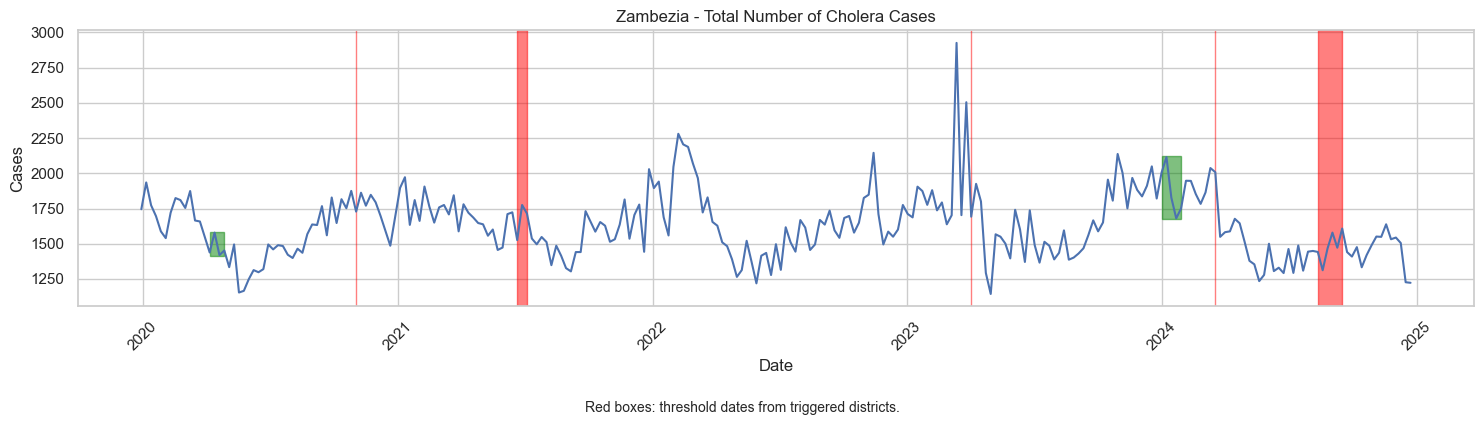

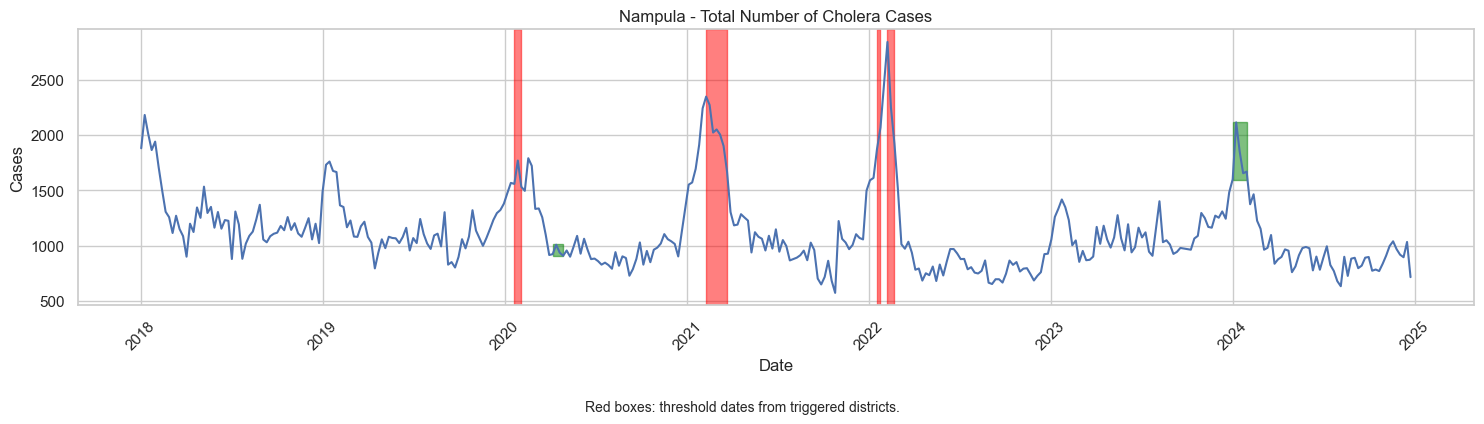

In [61]:
unique_provinces = district_df_with_percentiles["province"].unique()

for province in unique_provinces:
    # All districts in the province (include all, not just triggered ones)
    province_df = district_df_with_percentiles[
        district_df_with_percentiles["province"] == province
    ]

    if province_df.empty:
        continue

    agg = (
        province_df.groupby("date")
        .agg({"cases": "sum", "cases_per_100k": "sum"})
        .reset_index()
    )

    # Get all threshold dates from triggered districts in this province
    subset_trigger = district_df_with_percentiles[
        (district_df_with_percentiles["province"] == province)
        & (
            district_df_with_percentiles["district"].isin(
                district_trigger_99th["district"].unique()
            )
        )
    ]

    threshold_dates = subset_trigger[subset_trigger["three_consec_crossing"]][
        "date"
    ]

    agg["three_consec_crossing"] = agg["date"].isin(threshold_dates)

    # Plot
    plt.figure(figsize=(15, 4))
    sns.lineplot(data=agg, x="date", y="cases")

    # for date in red_line_dates:
    #    plt.axvline(x=date, color="red", linestyle="-", linewidth=1)

    highlight_month_boxes(agg, cerf_y_lim="cases")
    plt.title(f"{province} - Total Number of Cholera Cases")
    plt.xlabel("Date")
    plt.ylabel("Cases")
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.figtext(
        0.5,
        -0.05,
        "Red boxes: threshold dates from triggered districts.",
        wrap=True,
        horizontalalignment="center",
        fontsize=10,
    )
    plt.show()